<a href="https://www.kaggle.com/code/kwodus/cv-har?scriptVersionId=282388731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## MOJ

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

def arccos_safe(x):
    return np.arccos(np.clip(x, -1.0, 1.0))

def normalize_to_rgb(coords):
    min_val = np.min(coords)
    max_val = np.max(coords)
    norm_coords = 255 * (coords - min_val) / (max_val - min_val + 1e-8)
    return norm_coords.astype(np.uint8)

def compute_motion_of_joints(skeleton_sequence):
    Sx = normalize_to_rgb(skeleton_sequence[:, :, 0])
    Sy = normalize_to_rgb(skeleton_sequence[:, :, 1])
    Sz = normalize_to_rgb(skeleton_sequence[:, :, 2])
    motion = np.stack([Sx, Sy, Sz], axis=2)   # (N,J,3)
    return motion

def compute_pose_orientation(skeleton_sequence):
    N, J, _ = skeleton_sequence.shape
    pose_orientation = np.zeros((N, J, 3))
    for t in range(N):
        for i in range(J):
            for j in range(J):
                if i == j:
                    continue
                diff = skeleton_sequence[t, i] - skeleton_sequence[t, j]
                norm = np.linalg.norm(diff) + 1e-8
                normalized = diff / norm
                pose_orientation[t, i] += arccos_safe(normalized)
            pose_orientation[t, i] /= (J - 1)
    return normalize_to_rgb(pose_orientation)

def compute_transition_orientation(skeleton_sequence):
    N, J, _ = skeleton_sequence.shape
    transition_orientation = np.zeros((N, J, 3))
    for t in range(1, N):
        for i in range(J):
            for j in range(J):
                if i == j:
                    continue
                diff = skeleton_sequence[t, i] - skeleton_sequence[t-1, j]
                norm = np.linalg.norm(diff) + 1e-8
                normalized = diff / norm
                transition_orientation[t, i] += arccos_safe(normalized)
            transition_orientation[t, i] /= (J - 1)
    return normalize_to_rgb(transition_orientation)

def build_moj_image_side_by_side(motion, pose, transition):
    N, J, _ = motion.shape
    pose_resized = cv2.resize(pose, (J, N), interpolation=cv2.INTER_CUBIC)
    transition_resized = cv2.resize(transition, (J, N), interpolation=cv2.INTER_CUBIC)
    PT_side = np.hstack([pose_resized, transition_resized])
    combined = np.hstack([motion, PT_side]).astype(np.float32)

    mn, mx = combined.min(), combined.max()
    if mx - mn < 1e-8:
        norm_img = np.zeros_like(combined, dtype=np.uint8)
    else:
        norm_img = 255.0 * (combined - mn) / (mx - mn)
        norm_img = np.clip(norm_img, 0, 255).astype(np.uint8)

    final = cv2.resize(norm_img, (224, 224), interpolation=cv2.INTER_CUBIC)
    return final

def load_skeleton_file(filepath):
    joints = []
    with open(filepath, 'r') as f:
        lines = f.read().strip().split('\n')
        for line in lines[1:]:
            if not line.strip(): continue
            parts = line.strip().split(',')
            if len(parts) < 3: continue
            x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
            joints.append([x, y, z])
    return np.array(joints, dtype=np.float32)

def load_sequence_skeletons(sequence_path, expected_joints=20):
    file_list_path = os.path.join(sequence_path, 'fileList.txt')
    frames = []
    with open(file_list_path, 'r') as f:
        for line in f:
            frame_id = line.strip().split()[0]
            skeleton_file = None
            for file in os.listdir(sequence_path):
                if file.startswith(f"frame_{frame_id}_") and file.endswith("_skeletons.txt"):
                    skeleton_file = file
                    break
            if skeleton_file is None: continue
            joints = load_skeleton_file(os.path.join(sequence_path, skeleton_file))
            if joints.shape[0] == expected_joints:
                frames.append(joints)
    return np.stack(frames) if frames else None

def process_nucla_dataset(base_path, output_dir):
    views_dir = os.path.join(base_path, 'multiview_action')
    os.makedirs(output_dir, exist_ok=True)

    moj_image_paths = []
    view_folders = [v for v in sorted(os.listdir(views_dir)) if os.path.isdir(os.path.join(views_dir, v))]

    for view_folder in view_folders:
        view_path = os.path.join(views_dir, view_folder)
        seq_folders = [s for s in sorted(os.listdir(view_path)) if os.path.isdir(os.path.join(view_path, s))]
        
        view_output_dir = os.path.join(output_dir, view_folder)
        os.makedirs(view_output_dir, exist_ok=True)

        print(f"Processing view: {view_folder} ({len(seq_folders)} sequences)")
        for seq_folder in tqdm(seq_folders, desc=f"{view_folder} sequences"):
            seq_path = os.path.join(view_path, seq_folder)
            skeleton_sequence = load_sequence_skeletons(seq_path)
            if skeleton_sequence is None:
                continue

            motion = compute_motion_of_joints(skeleton_sequence)
            pose = compute_pose_orientation(skeleton_sequence)
            transition = compute_transition_orientation(skeleton_sequence)
            moj_image = build_moj_image_side_by_side(motion, pose, transition)

            save_path = os.path.join(view_output_dir, f"{seq_folder}.png")
            cv2.imwrite(save_path, cv2.cvtColor(moj_image, cv2.COLOR_RGB2BGR))
            moj_image_paths.append(save_path)
    return moj_image_paths


base_path = '/kaggle/input/n-ucla'
output_moj_dir = '/kaggle/working/moj_images'

moj_image_paths = process_nucla_dataset(base_path, output_moj_dir)



Processing view: view_1 (518 sequences)


view_1 sequences: 100%|██████████| 518/518 [08:50<00:00,  1.02s/it]


Processing view: view_2 (509 sequences)


view_2 sequences: 100%|██████████| 509/509 [05:35<00:00,  1.52it/s]


Processing view: view_3 (467 sequences)


view_3 sequences: 100%|██████████| 467/467 [04:34<00:00,  1.70it/s]


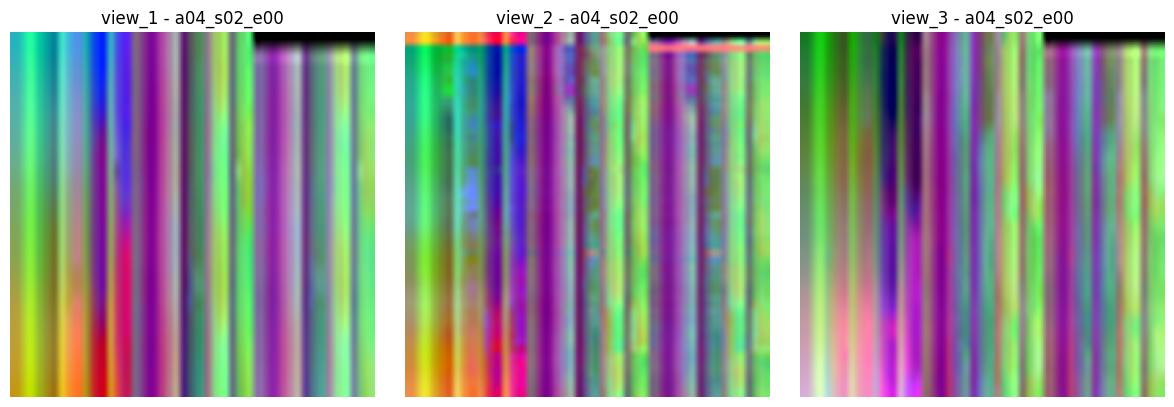

In [2]:
def visualize_moj_for_sequence(output_dir, sequence_name):
    views = ["view_1", "view_2", "view_3"]
    plt.figure(figsize=(12, 4))
    
    for i, view in enumerate(views):
        img_path = os.path.join(output_dir, view, f"{sequence_name}.png")
        if not os.path.exists(img_path):
            print(f"Not found: {img_path}")
            continue
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.title(f"{view} - {sequence_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_moj_for_sequence(output_moj_dir, "a04_s02_e00")

## ED-MHI

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def compute_ed_mhi(sequence_path, target_size=(224, 224)):
    depth_files = sorted([f for f in os.listdir(sequence_path) if f.endswith("_depth_vis.jpg")])
    if not depth_files:
        return None
    
    frames = []
    for file in depth_files:
        img_path = os.path.join(sequence_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        edges = cv2.Canny(img, 100, 200)
        frames.append(edges)

    if len(frames) == 0:
        return None

    N = len(frames)
    h, w = frames[0].shape
    MHI = np.zeros((h, w), dtype=np.float32)

    for t, frame in enumerate(frames):
        weight = ((t + 1) * 255) / N
        MHI += weight * frame

    MHI = np.clip(MHI, 0, 255).astype(np.uint8)

    # Resize to target size (224x224)
    MHI_resized = cv2.resize(MHI, target_size, interpolation=cv2.INTER_AREA)

    return MHI_resized


def process_nucla_ed_mhi(base_path, output_dir, target_size=(224, 224)):
    views_dir = os.path.join(base_path, 'multiview_action')
    os.makedirs(output_dir, exist_ok=True)

    ed_mhi_paths = []
    view_folders = [v for v in sorted(os.listdir(views_dir)) if os.path.isdir(os.path.join(views_dir, v))]

    for view_folder in view_folders:
        view_path = os.path.join(views_dir, view_folder)
        seq_folders = [s for s in sorted(os.listdir(view_path)) if os.path.isdir(os.path.join(view_path, s))]
        
        # Make subfolder for this view
        view_output_dir = os.path.join(output_dir, view_folder)
        os.makedirs(view_output_dir, exist_ok=True)

        print(f"Processing view: {view_folder} ({len(seq_folders)} sequences)")
        for seq_folder in tqdm(seq_folders, desc=f"{view_folder} sequences"):
            seq_path = os.path.join(view_path, seq_folder)
            mhi_img = compute_ed_mhi(seq_path, target_size)
            if mhi_img is None:
                continue

            save_path = os.path.join(view_output_dir, f"{seq_folder}.jpg")
            cv2.imwrite(save_path, mhi_img)  # saved as grayscale 224x224
            ed_mhi_paths.append(save_path)

    return ed_mhi_paths


base_path = '/kaggle/input/n-ucla'
output_ed_mhi_dir = '/kaggle/working/ed_mhi'

ed_mhi_paths = process_nucla_ed_mhi(base_path, output_ed_mhi_dir, target_size=(224, 224))


Processing view: view_1 (518 sequences)


view_1 sequences: 100%|██████████| 518/518 [01:00<00:00,  8.53it/s]


Processing view: view_2 (509 sequences)


view_2 sequences: 100%|██████████| 509/509 [00:42<00:00, 11.84it/s]


Processing view: view_3 (467 sequences)


view_3 sequences: 100%|██████████| 467/467 [00:31<00:00, 14.74it/s]


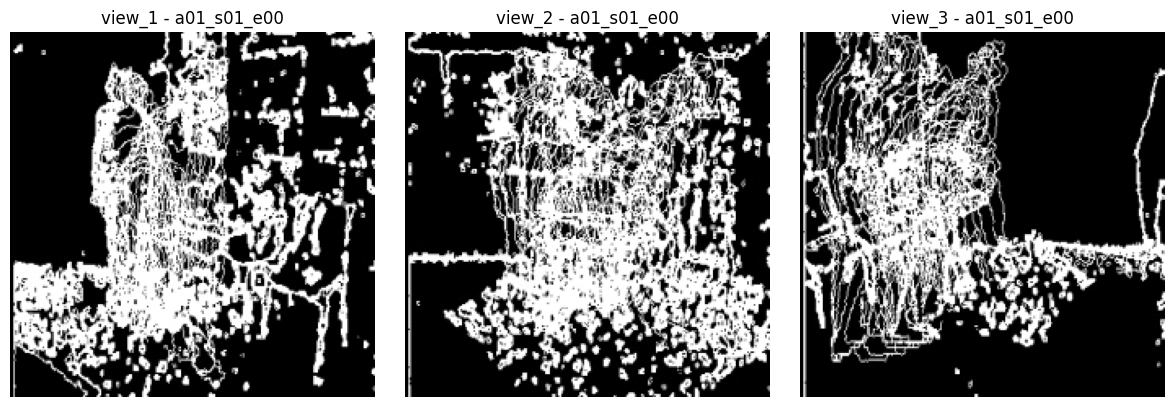

In [8]:
def visualize_ed_mhi_for_sequence(output_dir, sequence_name):
    views = ["view_1", "view_2", "view_3"]
    plt.figure(figsize=(12, 4))
    
    for i, view in enumerate(views):
        img_path = os.path.join(output_dir, view, f"{sequence_name}.jpg")
        if not os.path.exists(img_path):
            print(f"Not found: {img_path}")
            continue
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{view} - {sequence_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_ed_mhi_for_sequence(output_ed_mhi_dir, "a01_s01_e00")

## Train-Test Split

In [9]:
import os
import re

def parse_subject_id(fname):
    m = re.search(r"s\d{2}", fname)
    return m.group(0) if m else None

def parse_action_id(fname):
    m = re.match(r"(a\d{2}_s\d{2}_e\d{2})", fname)
    return m.group(1) if m else None

def collect_samples(root_dir):
    view_samples = {}
    for view in ["view_1", "view_2", "view_3"]:
        view_path = os.path.join(root_dir, view)
        files = [f for f in os.listdir(view_path) if f.lower().endswith((".jpg", ".png"))]
        
        samples = {}
        for f in files:
            sid = parse_subject_id(f)
            aid = parse_action_id(f)
            if sid and aid:
                samples[aid] = (os.path.join(view_path, f), sid)
        view_samples[view] = samples
    return view_samples

def intersect_views(view_samples):
    keys1 = set(view_samples["view_1"].keys())
    keys2 = set(view_samples["view_2"].keys())
    keys3 = set(view_samples["view_3"].keys())
    return keys1 & keys2 & keys3

def split_cs_protocol(view_samples, common_keys):
    train, test = {v: [] for v in view_samples}, {v: [] for v in view_samples}
    for aid in common_keys:
        for v in view_samples:
            path, sid = view_samples[v][aid]
            if sid in [f"s{str(i).zfill(2)}" for i in range(1, 10)]:
                train[v].append((path, sid, aid))
            elif sid == "s10":
                test[v].append((path, sid, aid))
    return train, test


moj_root = "/kaggle/working/moj_images"
ed_mhi_root = "/kaggle/working/ed_mhi"

moj_samples = collect_samples(moj_root)
ed_mhi_samples = collect_samples(ed_mhi_root)

moj_common = intersect_views(moj_samples)
ed_mhi_common = intersect_views(ed_mhi_samples)

all_common = moj_common & ed_mhi_common
print("Total common samples across 3 views (MOJ + ED-MHI):", len(all_common))

train_set, test_set = split_cs_protocol(moj_samples, all_common)


Total common samples across 3 views (MOJ + ED-MHI): 429


## CNN and Fusion CNN model

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def build_cnn(input_shape, num_classes, l2_reg=0.0001, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (7,7), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg),
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (5,5), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(512, (2,2), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model
    
def build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes, l2_reg=0.0001, dropout_rate=0.5):
    # Subchannel 1: MOJ
    moj_input = layers.Input(shape=input_shape_moj)
    x1 = layers.Conv2D(32, (7,7), activation='relu', padding='same')(moj_input)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(64, (5,5), activation='relu')(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(128, (3,3), activation='relu')(x1)
    x1 = layers.Conv2D(256, (3,3), activation='relu')(x1)
    x1 = layers.Conv2D(512, (2,2), activation='relu')(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)  

    # Subchannel 2: ED-MHI
    edmhi_input = layers.Input(shape=input_shape_edmhi)
    x2 = layers.Conv2D(32, (7,7), activation='relu', padding='same')(edmhi_input)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(64, (5,5), activation='relu')(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(128, (3,3), activation='relu')(x2)
    x2 = layers.Conv2D(256, (3,3), activation='relu')(x2)
    x2 = layers.Conv2D(512, (2,2), activation='relu')(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)  

    # Fusion
    fused = layers.Concatenate()([x1, x2])
    fused = layers.Dropout(dropout_rate)(fused)
    fused = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(fused)
    fused = layers.Dropout(dropout_rate)(fused)
    fused = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(fused)
    output = layers.Dense(num_classes, activation='softmax')(fused)

    return models.Model(inputs=[moj_input, edmhi_input], outputs=output)


## Train and Test for all views at once, 30 epochs

In [ ]:
def load_image(path, target_size=(224,224), is_moj=True):
    if is_moj:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype("float32") / 255.0
    else:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = np.expand_dims(img, axis=-1)
        img = img.astype("float32") / 255.0
    return img


def build_dataset(moj_samples, ed_mhi_samples, sample_list, num_classes, target_size=(224,224)):
    X_moj, X_edmhi, y = [], [], []
    for aid in tqdm(sample_list, desc="Loading dataset"):
        for v in ["view_1", "view_2", "view_3"]:
            moj_path, _ = moj_samples[v][aid]
            edmhi_path, _ = ed_mhi_samples[v][aid]
            X_moj.append(load_image(moj_path, target_size, is_moj=True))
            X_edmhi.append(load_image(edmhi_path, target_size, is_moj=False))
            label = aid.split("_")[0]  # "a01"
            y.append(label)

    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    y_cat = to_categorical(y_enc, num_classes=num_classes)
    return np.array(X_moj), np.array(X_edmhi), np.array(y_cat), le
    
def train_and_eval(model, X_train, y_train, X_test, y_test, inputs="moj"):
    print(f"\nTraining {inputs} model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=30,
                        batch_size=64,
                        verbose=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{inputs} Test Accuracy: {acc:.4f}")
    return history
    
def plot_training(history, title="Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


num_classes = 10  
input_shape_moj = (224,224,3)
input_shape_edmhi = (224,224,1)


train_ids = [aid for aid in all_common if parse_subject_id(aid) in [f"s{str(i).zfill(2)}" for i in range(1,10)]]
test_ids = [aid for aid in all_common if parse_subject_id(aid) == "s10"]


X_moj_train, X_edmhi_train, y_train, le = build_dataset(moj_samples, ed_mhi_samples, train_ids, num_classes)
X_moj_test, X_edmhi_test, y_test, _ = build_dataset(moj_samples, ed_mhi_samples, test_ids, num_classes)


moj_model = build_cnn(input_shape_moj, num_classes)
history_moj = train_and_eval(moj_model, X_moj_train, y_train, X_moj_test, y_test, inputs="MOJ")
plot_training(history_moj, title="MOJ")


edmhi_model = build_cnn(input_shape_edmhi, num_classes)
history_edmhi = train_and_eval(edmhi_model, X_edmhi_train, y_train, X_edmhi_test, y_test, inputs="ED-MHI")
plot_training(history_edmhi, title="ED-MHI")


fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
print("\nTraining Fusion model.")
fusion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])
history_fusion = fusion_model.fit([X_moj_train, X_edmhi_train], y_train,
                 validation_data=([X_moj_test, X_edmhi_test], y_test),
                 epochs=30,
                 batch_size=64,
                 verbose=1)
loss, acc = fusion_model.evaluate([X_moj_test, X_edmhi_test], y_test, verbose=0)
print(f"Fusion Test Accuracy: {acc:.4f}")
plot_training(history_fusion, title="Fusion")

## Train and Test for all views, 60 epochs

In [ ]:
def train_and_eval(model, X_train, y_train, X_test, y_test, inputs="moj"):
    print(f"\nTraining {inputs} model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=60,
                        batch_size=64,
                        verbose=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{inputs} Test Accuracy: {acc:.4f}")
    return history

def plot_training(history, title="Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


num_classes = 10  
input_shape_moj = (224,224,3)
input_shape_edmhi = (224,224,1)

train_ids = [aid for aid in all_common if parse_subject_id(aid) in [f"s{str(i).zfill(2)}" for i in range(1,10)]]
test_ids = [aid for aid in all_common if parse_subject_id(aid) == "s10"]

X_moj_train, X_edmhi_train, y_train, le = build_dataset(moj_samples, ed_mhi_samples, train_ids, num_classes)
X_moj_test, X_edmhi_test, y_test, _ = build_dataset(moj_samples, ed_mhi_samples, test_ids, num_classes)

moj_model = build_cnn(input_shape_moj, num_classes)
history_moj = train_and_eval(moj_model, X_moj_train, y_train, X_moj_test, y_test, inputs="MOJ")
plot_training(history_moj, title="MOJ")

edmhi_model = build_cnn(input_shape_edmhi, num_classes)
history_edmhi = train_and_eval(edmhi_model, X_edmhi_train, y_train, X_edmhi_test, y_test, inputs="ED-MHI")
plot_training(history_edmhi, title="ED-MHI")

fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
print("\nTraining Fusion model...")
fusion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])
history_fusion = fusion_model.fit([X_moj_train, X_edmhi_train], y_train,
                 validation_data=([X_moj_test, X_edmhi_test], y_test),
                 epochs=60,
                 batch_size=64,
                 verbose=1)
loss, acc = fusion_model.evaluate([X_moj_test, X_edmhi_test], y_test, verbose=0)
print(f"Fusion Test Accuracy: {acc:.4f}")
plot_training(history_fusion, title="Fusion")

## Train and Test for all views, 100 epochs

In [ ]:
def train_and_eval(model, X_train, y_train, X_test, y_test, inputs="moj"):
    print(f"\nTraining {inputs} model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        batch_size=64,
                        verbose=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{inputs} Test Accuracy: {acc:.4f}")
    return history

def plot_training(history, title="Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


num_classes = 10  
input_shape_moj = (224,224,3)
input_shape_edmhi = (224,224,1)

train_ids = [aid for aid in all_common if parse_subject_id(aid) in [f"s{str(i).zfill(2)}" for i in range(1,10)]]
test_ids = [aid for aid in all_common if parse_subject_id(aid) == "s10"]

X_moj_train, X_edmhi_train, y_train, le = build_dataset(moj_samples, ed_mhi_samples, train_ids, num_classes)
X_moj_test, X_edmhi_test, y_test, _ = build_dataset(moj_samples, ed_mhi_samples, test_ids, num_classes)

moj_model = build_cnn(input_shape_moj, num_classes)
history_moj = train_and_eval(moj_model, X_moj_train, y_train, X_moj_test, y_test, inputs="MOJ")
plot_training(history_moj, title="MOJ")

edmhi_model = build_cnn(input_shape_edmhi, num_classes)
history_edmhi = train_and_eval(edmhi_model, X_edmhi_train, y_train, X_edmhi_test, y_test, inputs="ED-MHI")
plot_training(history_edmhi, title="ED-MHI")

fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
print("\nTraining Fusion model...")
fusion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])
history_fusion = fusion_model.fit([X_moj_train, X_edmhi_train], y_train,
                 validation_data=([X_moj_test, X_edmhi_test], y_test),
                 epochs=60,
                 batch_size=64,
                 verbose=1)
loss, acc = fusion_model.evaluate([X_moj_test, X_edmhi_test], y_test, verbose=0)
print(f"Fusion Test Accuracy: {acc:.4f}")
plot_training(history_fusion, title="Fusion")

In [ ]:
def train_and_eval(model, X_train, y_train, X_test, y_test, inputs="moj"):
    print(f"\nTraining {inputs} model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        batch_size=64,
                        verbose=1)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{inputs} Test Accuracy: {acc:.4f}")
    return history

def plot_training(history, title="Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


num_classes = 10  # adjust to number of actions you actually have
input_shape_moj = (224,224,3)
input_shape_edmhi = (224,224,1)

# CS protocol sets (already prepared earlier)
train_ids = [aid for aid in all_common if parse_subject_id(aid) in [f"s{str(i).zfill(2)}" for i in range(1,10)]]
test_ids = [aid for aid in all_common if parse_subject_id(aid) == "s10"]

# Build datasets
X_moj_train, X_edmhi_train, y_train, le = build_dataset(moj_samples, ed_mhi_samples, train_ids, num_classes)
X_moj_test, X_edmhi_test, y_test, _ = build_dataset(moj_samples, ed_mhi_samples, test_ids, num_classes)

# # ---- Train MOJ-only ----
# moj_model = build_cnn(input_shape_moj, num_classes)
# history_moj = train_and_eval(moj_model, X_moj_train, y_train, X_moj_test, y_test, inputs="MOJ")
# plot_training(history_moj, title="MOJ")

# # ---- Train ED-MHI-only ----
# edmhi_model = build_cnn(input_shape_edmhi, num_classes)
# history_edmhi = train_and_eval(edmhi_model, X_edmhi_train, y_train, X_edmhi_test, y_test, inputs="ED-MHI")
# plot_training(history_edmhi, title="ED-MHI")

# ---- Train Fusion ----
fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
print("\nTraining Fusion model...")
fusion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])
history_fusion = fusion_model.fit([X_moj_train, X_edmhi_train], y_train,
                 validation_data=([X_moj_test, X_edmhi_test], y_test),
                 epochs=100,
                 batch_size=64,
                 verbose=1)
loss, acc = fusion_model.evaluate([X_moj_test, X_edmhi_test], y_test, verbose=0)
print(f"Fusion Test Accuracy: {acc:.4f}")
plot_training(history_fusion, title="Fusion")

## View-wise, 30 epochs

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

IMG_SIZE = (224, 224)
views = ["view_1", "view_2", "view_3"]

# -------------------------------
# 1. Auto-detect number of classes
# -------------------------------
def detect_num_classes(train_set, test_set):
    all_aids = []
    for view in views:
        all_aids += [aid for (_, _, aid) in train_set[view]]
        all_aids += [aid for (_, _, aid) in test_set[view]]
    unique_actions = sorted(set(all_aids))
    print(f"Detected {len(unique_actions)} classes: {unique_actions[:10]}...")
    return len(unique_actions)

# -------------------------------
# 2. Data loader per view
# -------------------------------
def load_images_per_view(train_set, test_set, num_classes):
    X_moj_train, X_moj_test = {}, {}
    X_edmhi_train, X_edmhi_test = {}, {}
    y_train_cat, y_test_cat = {}, {}
    
    for view in views:
        # ---- File paths ----
        train_paths = [p for (p, sid, aid) in train_set[view]]
        test_paths  = [p for (p, sid, aid) in test_set[view]]
        
        # ---- MOJ ----
        X_moj_train[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(train_paths, desc=f"Loading MOJ train {view}") if "moj" in p.lower()
        ])
        X_moj_test[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(test_paths, desc=f"Loading MOJ test {view}") if "moj" in p.lower()
        ])

        # ---- ED-MHI ----
        X_edmhi_train[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(train_paths, desc=f"Loading ED-MHI train {view}")
        ])
        X_edmhi_test[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(test_paths, desc=f"Loading ED-MHI test {view}")
        ])

        print(f"{view} - ED-MHI train samples:", len(train_paths))
        print(f"{view} - ED-MHI test samples:", len(test_paths))

        # ---- Labels ----
        y_train = [int(aid[1:3]) - 1 for (p, sid, aid) in train_set[view]]
        y_test  = [int(aid[1:3]) - 1 for (p, sid, aid) in test_set[view]]
        
        y_train_cat[view] = to_categorical(y_train, num_classes)
        y_test_cat[view]  = to_categorical(y_test, num_classes)
    
    return X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat

# -------------------------------
# 3. Training loop for MOJ, ED-MHI, Fusion
# -------------------------------
moj_accuracies = {}
edmhi_accuracies = {}
fusion_accuracies = {}

# auto-detect num_classes
num_classes = detect_num_classes(train_set, test_set)

# load data
X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat = load_images_per_view(train_set, test_set, num_classes)

for view in views:
    print(f"\n===== {view.upper()} =====")
    
    # ---- MOJ ----
    print(f"Training MOJ model on {view}...")
    moj_model = build_cnn(input_shape_moj, num_classes)
    moj_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_moj = moj_model.fit(
        X_moj_train[view], y_train_cat[view],
        validation_data=(X_moj_test[view], y_test_cat[view]),
        epochs=30, batch_size=32, verbose=1
    )
    _, acc = moj_model.evaluate(X_moj_test[view], y_test_cat[view], verbose=0)
    moj_accuracies[view] = acc
    print(f"MOJ {view} Test Accuracy: {acc:.4f}")
    graph_title = "MOJ"+ view 
    plot_training(history_moj, title=graph_title)


    # ---- ED-MHI ----
    print(f"Training ED-MHI model on {view}...")
    edmhi_model = build_cnn(input_shape_edmhi, num_classes)
    edmhi_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_edmhi = edmhi_model.fit(
        X_edmhi_train[view], y_train_cat[view],
        validation_data=(X_edmhi_test[view], y_test_cat[view]),
        epochs=30, batch_size=32, verbose=1
    )
    _, acc = edmhi_model.evaluate(X_edmhi_test[view], y_test_cat[view], verbose=0)
    edmhi_accuracies[view] = acc
    print(f"ED-MHI {view} Test Accuracy: {acc:.4f}")
    graph_title = "EDMHI"+ view 
    plot_training(history_edmhi, title=graph_title)

    # ---- Fusion ----
    print(f"Training Fusion model on {view}...")
    fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
    fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_fusion = fusion_model.fit(
        [X_moj_train[view], X_edmhi_train[view]], y_train_cat[view],
        validation_data=([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view]),
        epochs=30, batch_size=32, verbose=1
    )
    _, acc = fusion_model.evaluate([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view], verbose=0)
    fusion_accuracies[view] = acc
    print(f"Fusion {view} Test Accuracy: {acc:.4f}")
    graph_title = "Fusion"+ view 
    plot_training(history_fusion, title=graph_title)

# -------------------------------
# 4. Print summary
# -------------------------------
print("\n===== FINAL RESULTS =====")
for view in views:
    print(f"{view.upper()} -> MOJ: {moj_accuracies[view]:.4f}, "
          f"ED-MHI: {edmhi_accuracies[view]:.4f}, "
          f"Fusion: {fusion_accuracies[view]:.4f}")


## View wise, 60 epochs

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

IMG_SIZE = (224, 224)
views = ["view_1", "view_2", "view_3"]

# -------------------------------
# 1. Auto-detect number of classes
# -------------------------------
def detect_num_classes(train_set, test_set):
    all_aids = []
    for view in views:
        all_aids += [aid for (_, _, aid) in train_set[view]]
        all_aids += [aid for (_, _, aid) in test_set[view]]
    unique_actions = sorted(set(all_aids))
    print(f"Detected {len(unique_actions)} classes: {unique_actions[:10]}...")
    return len(unique_actions)

# -------------------------------
# 2. Data loader per view
# -------------------------------
def load_images_per_view(train_set, test_set, num_classes):
    X_moj_train, X_moj_test = {}, {}
    X_edmhi_train, X_edmhi_test = {}, {}
    y_train_cat, y_test_cat = {}, {}
    
    for view in views:
        # ---- File paths ----
        train_paths = [p for (p, sid, aid) in train_set[view]]
        test_paths  = [p for (p, sid, aid) in test_set[view]]
        
        # ---- MOJ ----
        X_moj_train[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(train_paths, desc=f"Loading MOJ train {view}") if "moj" in p.lower()
        ])
        X_moj_test[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(test_paths, desc=f"Loading MOJ test {view}") if "moj" in p.lower()
        ])

        # ---- ED-MHI ----
        X_edmhi_train[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(train_paths, desc=f"Loading ED-MHI train {view}")
        ])
        X_edmhi_test[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(test_paths, desc=f"Loading ED-MHI test {view}")
        ])

        print(f"{view} - ED-MHI train samples:", len(train_paths))
        print(f"{view} - ED-MHI test samples:", len(test_paths))

        # ---- Labels ----
        y_train = [int(aid[1:3]) - 1 for (p, sid, aid) in train_set[view]]
        y_test  = [int(aid[1:3]) - 1 for (p, sid, aid) in test_set[view]]
        
        y_train_cat[view] = to_categorical(y_train, num_classes)
        y_test_cat[view]  = to_categorical(y_test, num_classes)
    
    return X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat

# -------------------------------
# 3. Training loop for MOJ, ED-MHI, Fusion
# -------------------------------
moj_accuracies = {}
edmhi_accuracies = {}
fusion_accuracies = {}

# auto-detect num_classes
num_classes = detect_num_classes(train_set, test_set)

# load data
X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat = load_images_per_view(train_set, test_set, num_classes)

for view in views:
    print(f"\n===== {view.upper()} =====")
    
    # ---- MOJ ----
    print(f"Training MOJ model on {view}...")
    moj_model = build_cnn(input_shape_moj, num_classes)
    moj_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_moj = moj_model.fit(
        X_moj_train[view], y_train_cat[view],
        validation_data=(X_moj_test[view], y_test_cat[view]),
        epochs=60, batch_size=32, verbose=1
    )
    _, acc = moj_model.evaluate(X_moj_test[view], y_test_cat[view], verbose=0)
    moj_accuracies[view] = acc
    print(f"MOJ {view} Test Accuracy: {acc:.4f}")
    graph_title = "MOJ"+ view 
    plot_training(history_moj, title=graph_title)


    # ---- ED-MHI ----
    print(f"Training ED-MHI model on {view}...")
    edmhi_model = build_cnn(input_shape_edmhi, num_classes)
    edmhi_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_edmhi = edmhi_model.fit(
        X_edmhi_train[view], y_train_cat[view],
        validation_data=(X_edmhi_test[view], y_test_cat[view]),
        epochs=60, batch_size=32, verbose=1
    )
    _, acc = edmhi_model.evaluate(X_edmhi_test[view], y_test_cat[view], verbose=0)
    edmhi_accuracies[view] = acc
    print(f"ED-MHI {view} Test Accuracy: {acc:.4f}")
    graph_title = "EDMHI"+ view 
    plot_training(history_edmhi, title=graph_title)

    # ---- Fusion ----
    print(f"Training Fusion model on {view}...")
    fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
    fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_fusion = fusion_model.fit(
        [X_moj_train[view], X_edmhi_train[view]], y_train_cat[view],
        validation_data=([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view]),
        epochs=60, batch_size=32, verbose=1
    )
    _, acc = fusion_model.evaluate([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view], verbose=0)
    fusion_accuracies[view] = acc
    print(f"Fusion {view} Test Accuracy: {acc:.4f}")
    graph_title = "Fusion"+ view 
    plot_training(history_fusion, title=graph_title)

# -------------------------------
# 4. Print summary
# -------------------------------
print("\n===== FINAL RESULTS =====")
for view in views:
    print(f"{view.upper()} -> MOJ: {moj_accuracies[view]:.4f}, "
          f"ED-MHI: {edmhi_accuracies[view]:.4f}, "
          f"Fusion: {fusion_accuracies[view]:.4f}")


## View wise, 100 epochs

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

IMG_SIZE = (224, 224)
views = ["view_1", "view_2", "view_3"]

# -------------------------------
# 1. Auto-detect number of classes
# -------------------------------
def detect_num_classes(train_set, test_set):
    all_aids = []
    for view in views:
        all_aids += [aid for (_, _, aid) in train_set[view]]
        all_aids += [aid for (_, _, aid) in test_set[view]]
    unique_actions = sorted(set(all_aids))
    print(f"Detected {len(unique_actions)} classes: {unique_actions[:10]}...")
    return len(unique_actions)

# -------------------------------
# 2. Data loader per view
# -------------------------------
def load_images_per_view(train_set, test_set, num_classes):
    X_moj_train, X_moj_test = {}, {}
    X_edmhi_train, X_edmhi_test = {}, {}
    y_train_cat, y_test_cat = {}, {}
    
    for view in views:
        # ---- File paths ----
        train_paths = [p for (p, sid, aid) in train_set[view]]
        test_paths  = [p for (p, sid, aid) in test_set[view]]
        
        # ---- MOJ ----
        X_moj_train[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(train_paths, desc=f"Loading MOJ train {view}") if "moj" in p.lower()
        ])
        X_moj_test[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(test_paths, desc=f"Loading MOJ test {view}") if "moj" in p.lower()
        ])

        # ---- ED-MHI ----
        X_edmhi_train[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(train_paths, desc=f"Loading ED-MHI train {view}")
        ])
        X_edmhi_test[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(test_paths, desc=f"Loading ED-MHI test {view}")
        ])

        print(f"{view} - ED-MHI train samples:", len(train_paths))
        print(f"{view} - ED-MHI test samples:", len(test_paths))

        # ---- Labels ----
        y_train = [int(aid[1:3]) - 1 for (p, sid, aid) in train_set[view]]
        y_test  = [int(aid[1:3]) - 1 for (p, sid, aid) in test_set[view]]
        
        y_train_cat[view] = to_categorical(y_train, num_classes)
        y_test_cat[view]  = to_categorical(y_test, num_classes)
    
    return X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat

# -------------------------------
# 3. Training loop for MOJ, ED-MHI, Fusion
# -------------------------------
moj_accuracies = {}
edmhi_accuracies = {}
fusion_accuracies = {}

# auto-detect num_classes
num_classes = detect_num_classes(train_set, test_set)

# load data
X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat = load_images_per_view(train_set, test_set, num_classes)

for view in views:
    print(f"\n===== {view.upper()} =====")
    
    # ---- MOJ ----
    print(f"Training MOJ model on {view}...")
    moj_model = build_cnn(input_shape_moj, num_classes)
    moj_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_moj = moj_model.fit(
        X_moj_train[view], y_train_cat[view],
        validation_data=(X_moj_test[view], y_test_cat[view]),
        epochs=100, batch_size=32, verbose=1
    )
    _, acc = moj_model.evaluate(X_moj_test[view], y_test_cat[view], verbose=0)
    moj_accuracies[view] = acc
    print(f"MOJ {view} Test Accuracy: {acc:.4f}")
    graph_title = "MOJ"+ view 
    plot_training(history_moj, title=graph_title)


    # ---- ED-MHI ----
    print(f"Training ED-MHI model on {view}...")
    edmhi_model = build_cnn(input_shape_edmhi, num_classes)
    edmhi_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_edmhi = edmhi_model.fit(
        X_edmhi_train[view], y_train_cat[view],
        validation_data=(X_edmhi_test[view], y_test_cat[view]),
        epochs=100, batch_size=32, verbose=1
    )
    _, acc = edmhi_model.evaluate(X_edmhi_test[view], y_test_cat[view], verbose=0)
    edmhi_accuracies[view] = acc
    print(f"ED-MHI {view} Test Accuracy: {acc:.4f}")
    graph_title = "EDMHI"+ view 
    plot_training(history_edmhi, title=graph_title)

    # ---- Fusion ----
    print(f"Training Fusion model on {view}...")
    fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
    fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_fusion = fusion_model.fit(
        [X_moj_train[view], X_edmhi_train[view]], y_train_cat[view],
        validation_data=([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view]),
        epochs=100, batch_size=32, verbose=1
    )
    _, acc = fusion_model.evaluate([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view], verbose=0)
    fusion_accuracies[view] = acc
    print(f"Fusion {view} Test Accuracy: {acc:.4f}")
    graph_title = "Fusion"+ view 
    plot_training(history_fusion, title=graph_title)

# -------------------------------
# 4. Print summary
# -------------------------------
print("\n===== FINAL RESULTS =====")
for view in views:
    print(f"{view.upper()} -> MOJ: {moj_accuracies[view]:.4f}, "
          f"ED-MHI: {edmhi_accuracies[view]:.4f}, "
          f"Fusion: {fusion_accuracies[view]:.4f}")


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

IMG_SIZE = (224, 224)
views = ["view_1", "view_2", "view_3"]

# -------------------------------
# 1. Auto-detect number of classes
# -------------------------------
def detect_num_classes(train_set, test_set):
    all_aids = []
    for view in views:
        all_aids += [aid for (_, _, aid) in train_set[view]]
        all_aids += [aid for (_, _, aid) in test_set[view]]
    unique_actions = sorted(set(all_aids))
    print(f"Detected {len(unique_actions)} classes: {unique_actions[:10]}...")
    return len(unique_actions)

# -------------------------------
# 2. Data loader per view
# -------------------------------
def load_images_per_view(train_set, test_set, num_classes):
    X_moj_train, X_moj_test = {}, {}
    X_edmhi_train, X_edmhi_test = {}, {}
    y_train_cat, y_test_cat = {}, {}
    
    for view in views:
        # ---- File paths ----
        train_paths = [p for (p, sid, aid) in train_set[view]]
        test_paths  = [p for (p, sid, aid) in test_set[view]]
        
        # ---- MOJ ----
        X_moj_train[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(train_paths, desc=f"Loading MOJ train {view}") if "moj" in p.lower()
        ])
        X_moj_test[view] = np.array([
            cv2.resize(cv2.imread(p), IMG_SIZE) 
            for p in tqdm(test_paths, desc=f"Loading MOJ test {view}") if "moj" in p.lower()
        ])

        # ---- ED-MHI ----
        X_edmhi_train[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(train_paths, desc=f"Loading ED-MHI train {view}")
        ])
        X_edmhi_test[view] = np.array([
            cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), IMG_SIZE)[..., None]
            for p in tqdm(test_paths, desc=f"Loading ED-MHI test {view}")
        ])

        print(f"{view} - ED-MHI train samples:", len(train_paths))
        print(f"{view} - ED-MHI test samples:", len(test_paths))

        # ---- Labels ----
        y_train = [int(aid[1:3]) - 1 for (p, sid, aid) in train_set[view]]
        y_test  = [int(aid[1:3]) - 1 for (p, sid, aid) in test_set[view]]
        
        y_train_cat[view] = to_categorical(y_train, num_classes)
        y_test_cat[view]  = to_categorical(y_test, num_classes)
    
    return X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat

# -------------------------------
# 3. Training loop for MOJ, ED-MHI, Fusion
# -------------------------------
moj_accuracies = {}
edmhi_accuracies = {}
fusion_accuracies = {}

# auto-detect num_classes
num_classes = detect_num_classes(train_set, test_set)

# load data
X_moj_train, X_moj_test, X_edmhi_train, X_edmhi_test, y_train_cat, y_test_cat = load_images_per_view(train_set, test_set, num_classes)

for view in views:
    print(f"\n===== {view.upper()} =====")
    
    # # ---- MOJ ----
    # print(f"Training MOJ model on {view}...")
    # moj_model = build_cnn(input_shape_moj, num_classes)
    # moj_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # history_moj = moj_model.fit(
    #     X_moj_train[view], y_train_cat[view],
    #     validation_data=(X_moj_test[view], y_test_cat[view]),
    #     epochs=100, batch_size=32, verbose=1
    # )
    # _, acc = moj_model.evaluate(X_moj_test[view], y_test_cat[view], verbose=0)
    # moj_accuracies[view] = acc
    # print(f"MOJ {view} Test Accuracy: {acc:.4f}")
    # graph_title = "MOJ"+ view 
    # plot_training(history_moj, title=graph_title)


    # # ---- ED-MHI ----
    # print(f"Training ED-MHI model on {view}...")
    # edmhi_model = build_cnn(input_shape_edmhi, num_classes)
    # edmhi_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # history_edmhi = edmhi_model.fit(
    #     X_edmhi_train[view], y_train_cat[view],
    #     validation_data=(X_edmhi_test[view], y_test_cat[view]),
    #     epochs=100, batch_size=32, verbose=1
    # )
    # _, acc = edmhi_model.evaluate(X_edmhi_test[view], y_test_cat[view], verbose=0)
    # edmhi_accuracies[view] = acc
    # print(f"ED-MHI {view} Test Accuracy: {acc:.4f}")
    # graph_title = "EDMHI"+ view 
    # plot_training(history_edmhi, title=graph_title)

    # ---- Fusion ----
    print(f"Training Fusion model on {view}...")
    fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
    fusion_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history_fusion = fusion_model.fit(
        [X_moj_train[view], X_edmhi_train[view]], y_train_cat[view],
        validation_data=([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view]),
        epochs=100, batch_size=32, verbose=1
    )
    _, acc = fusion_model.evaluate([X_moj_test[view], X_edmhi_test[view]], y_test_cat[view], verbose=0)
    fusion_accuracies[view] = acc
    print(f"Fusion {view} Test Accuracy: {acc:.4f}")
    graph_title = "Fusion"+ view 
    plot_training(history_fusion, title=graph_title)

# -------------------------------
# 4. Print summary
# -------------------------------
print("\n===== FINAL RESULTS =====")
for view in views:
    print(f"Fusion: {fusion_accuracies[view]:.4f}")


## Cross view consistency loss

In [11]:
def load_image(path, target_size=(224,224), is_moj=True):
    if is_moj:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype("float32") / 255.0
    else:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size)
        img = np.expand_dims(img, axis=-1)
        img = img.astype("float32") / 255.0
    return img

def build_triplet_dataset(moj_samples, ed_mhi_samples, sample_list, target_size=(224,224), le=None):
    
    X1_moj, X2_moj, X3_moj = [], [], []
    X1_ed,  X2_ed,  X3_ed  = [], [], []
    y = []

    for aid in tqdm(sample_list, desc="Building triplet dataset"):

        # ---- Load 3 MOJ views ----
        p1_moj, _ = moj_samples["view_1"][aid]
        p2_moj, _ = moj_samples["view_2"][aid]
        p3_moj, _ = moj_samples["view_3"][aid]

        X1_moj.append(load_image(p1_moj, target_size, True))
        X2_moj.append(load_image(p2_moj, target_size, True))
        X3_moj.append(load_image(p3_moj, target_size, True))

        # ---- Load 3 ED-MHI views ----
        p1_ed, _ = ed_mhi_samples["view_1"][aid]
        p2_ed, _ = ed_mhi_samples["view_2"][aid]
        p3_ed, _ = ed_mhi_samples["view_3"][aid]

        X1_ed.append(load_image(p1_ed, target_size, False))
        X2_ed.append(load_image(p2_ed, target_size, False))
        X3_ed.append(load_image(p3_ed, target_size, False))

        # ---- Store class label ----
        y.append(aid.split("_")[0])   # e.g. "a01"

    # ---- Encode labels ----
    if le is None:
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
    else:
        y_enc = le.transform(y)

    num_classes = len(le.classes_)
    y_cat = to_categorical(y_enc, num_classes=num_classes)

    return (np.array(X1_moj), np.array(X2_moj), np.array(X3_moj),
            np.array(X1_ed),  np.array(X2_ed),  np.array(X3_ed),
            y_cat, le, num_classes)


In [12]:
class CrossViewModel(tf.keras.Model):
    def __init__(self, encoder, classifier, lambda_cv=0.1):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
        self.lambda_cv = lambda_cv
        self.loss_ce = tf.keras.losses.CategoricalCrossentropy()

        # VERY IMPORTANT: declare metrics
        self.train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        self.val_accuracy = tf.keras.metrics.CategoricalAccuracy()

        self.cv_loss_tracker = tf.keras.metrics.Mean(name="cv_loss")

    def train_step(self, data):
        (x1, x2, x3), y = data

        with tf.GradientTape() as tape:
            f1 = self.encoder(x1, training=True)
            f2 = self.encoder(x2, training=True)
            f3 = self.encoder(x3, training=True)

            logits = self.classifier((f1 + f2 + f3) / 3, training=True)

            CE = self.loss_ce(y, logits)
            CV = (
                tf.reduce_mean(tf.square(f1 - f2)) +
                tf.reduce_mean(tf.square(f2 - f3)) +
                tf.reduce_mean(tf.square(f1 - f3))
            )

            total_loss = CE + self.lambda_cv * CV

        grads = tape.gradient(total_loss, 
                self.encoder.trainable_variables + self.classifier.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.encoder.trainable_variables + self.classifier.trainable_variables)
        )

        # UPDATE METRICS
        self.train_accuracy.update_state(y, logits)
        self.cv_loss_tracker.update_state(CV)

        return {
            "loss": CE,                       # Keras loss
            "accuracy": self.train_accuracy.result(),
            "cv_loss": self.cv_loss_tracker.result() 
        }

    def test_step(self, data):
        (x1, x2, x3), y = data

        f1 = self.encoder(x1, training=False)
        f2 = self.encoder(x2, training=False)
        f3 = self.encoder(x3, training=False)

        logits = self.classifier((f1 + f2 + f3) / 3, training=False)
        CE = self.loss_ce(y, logits)

        self.val_accuracy.update_state(y, logits)

        return {
            "val_loss": CE,
            "val_accuracy": self.val_accuracy.result(),
        }


In [ ]:
def build_encoder(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (7,7), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (5,5), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3,3), activation='relu')(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    return tf.keras.Model(inp, x)

def build_classifier(num_classes):
    inp = tf.keras.Input(shape=(256,))
    out = layers.Dense(num_classes, activation='softmax')(inp)
    return tf.keras.Model(inp, out)


In [ ]:
lambda_cv = 0.01  # tune 0.01–0.2
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_ce = tf.keras.losses.CategoricalCrossentropy()


In [ ]:
# ------------------------------------------
# 1. Recompute train_ids and test_ids
# ------------------------------------------

# all_common = intersection of samples across 3 views (already computed before)
# If you don't have it defined, recompute it:
moj_common = intersect_views(moj_samples)
ed_mhi_common = intersect_views(ed_mhi_samples)
all_common = moj_common & ed_mhi_common
num_classes=10

# Train = s01–s09, Test = s10
train_ids = [aid for aid in all_common if parse_subject_id(aid) in [f"s{str(i).zfill(2)}" for i in range(1,10)]]
test_ids  = [aid for aid in all_common if parse_subject_id(aid) == "s10"]

print("Train samples:", len(train_ids))
print("Test samples:", len(test_ids))
# Load triplet dataset
# TRAIN
(X1_moj, X2_moj, X3_moj,
 X1_ed,  X2_ed,  X3_ed,
 Y, le, num_classes) = build_triplet_dataset(
       moj_samples, ed_mhi_samples, train_ids
)

# TEST (reuse encoder)
(X1_moj_test, X2_moj_test, X3_moj_test,
 X1_ed_test,  X2_ed_test,  X3_ed_test,
 Y_test, _, _) = build_triplet_dataset(
       moj_samples, ed_mhi_samples, test_ids, le=le
)




In [ ]:
# ---- Build encoder + classifier ----
encoder = build_encoder((224,224,3))
classifier = build_classifier(num_classes)
# encoder.trainable = False
model = CrossViewModel(encoder, classifier, lambda_cv=0.01)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005))

history = model.fit(
    [X1_moj, X2_moj, X3_moj], Y,
    validation_data=([X1_moj_test, X2_moj_test, X3_moj_test], Y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)


In [ ]:
history = cv_model.fit(
    [X1_moj, X2_moj, X3_moj], Y,
    validation_data=([X1_moj_test, X2_moj_test, X3_moj_test], Y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


In [ ]:
f1 = encoder(view1_img)
f2 = encoder(view2_img)
f3 = encoder(view3_img)

final_logits = classifier((f1+f2+f3)/3)


In [ ]:
F1 = concat(f1_moj, f1_ed)
F2 = concat(f2_moj, f2_ed)
F3 = concat(f3_moj, f3_ed)

L_cv = ||F1 − F2||² + ||F2 − F3||² + ||F1 − F3||²


## Cross View Consistency Loss

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def build_cnn(input_shape, num_classes, l2_reg=0.0001, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (7,7), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg),
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (5,5), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(512, (2,2), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model
    
def build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes, l2_reg=0.0001, dropout_rate=0.5):
    # Subchannel 1: MOJ
    moj_input = layers.Input(shape=input_shape_moj)
    x1 = layers.Conv2D(32, (7,7), activation='relu', padding='same')(moj_input)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(64, (5,5), activation='relu')(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)
    x1 = layers.Conv2D(128, (3,3), activation='relu')(x1)
    x1 = layers.Conv2D(256, (3,3), activation='relu')(x1)
    x1 = layers.Conv2D(512, (2,2), activation='relu')(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)   

    # Subchannel 2: ED-MHI
    edmhi_input = layers.Input(shape=input_shape_edmhi)
    x2 = layers.Conv2D(32, (7,7), activation='relu', padding='same')(edmhi_input)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(64, (5,5), activation='relu')(x2)
    x2 = layers.MaxPooling2D((2,2))(x2)
    x2 = layers.Conv2D(128, (3,3), activation='relu')(x2)
    x2 = layers.Conv2D(256, (3,3), activation='relu')(x2)
    x2 = layers.Conv2D(512, (2,2), activation='relu')(x2)
    x2 = layers.GlobalAveragePooling2D()(x2) 

    # Fusion
    fused = layers.Concatenate()([x1, x2])
    fused = layers.Dropout(dropout_rate)(fused)
    fused = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(fused)
    fused = layers.Dropout(dropout_rate)(fused)
    fused = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(fused)
    output = layers.Dense(num_classes, activation='softmax')(fused)

    return models.Model(inputs=[moj_input, edmhi_input], outputs=output)


In [4]:

input_shape_moj = (224, 224,3)
input_shape_edmhi = (224, 224, 1)
num_classes = 10
moj_model = build_cnn(input_shape_moj, num_classes)
print("=== MOJ model summary ===")
moj_model.summary()

edmhi_model = build_cnn(input_shape_edmhi, num_classes)
print("=== ED-MHI model summary ===")
edmhi_model.summary()

fusion_model = build_fusion_cnn(input_shape_moj, input_shape_edmhi, num_classes)
print("=== Fusion model summary ===")
fusion_model.summary()


=== MOJ model summary ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 108, 108, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,637,834 (29.14 MB)

 Trainable params: 7,637,834 (29.14 MB)

 Non-trainable params: 0 (0.00 B)

=== ED-MHI model summary ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 108, 108, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,634,698 (29.12 MB)

 Trainable params: 7,634,698 (29.12 MB)

 Non-trainable params: 0 (0.00 B)

=== Fusion model summary ===


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │      4,736 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │      1,600 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 112, 112,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 108, 108,  │     51,264 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 108, 108,  │     51,264 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 54, 54,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 54, 54,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 50, 50,    │    295,168 │ conv2d_17[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 50, 50,    │    295,168 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 49, 49,    │    524,800 │ conv2d_18[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 49, 49,    │    524,800 │ conv2d_23[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ conv2d_19[0][0] 

 Total params: 2,555,210 (9.75 MB)

 Trainable params: 2,555,210 (9.75 MB)

 Non-trainable params: 0 (0.00 B)